## Hyperparameter Sweep for BERT-based Text Classification

### Maximize Precision with a Recall Floor By Using Adjusted Class Weights
This notebook performs a random search for the best hyperparameters for a BERT-based text classification model.

The goal is to find the model and classification threshold that maximize precision while ensuring recall stays above a reasonable threshold (e.g., 25%). It uses manually adjusted class weights to find a balance between precision and recall.

In [ ]:
# After installations if the tf version is inconsistent the runtime might crash
# If that happens, use the `os.kill` line and proceed to next
import os

!pip install -q --upgrade --force-reinstall \
    numpy==1.23.5 \
    tensorflow==2.12.1 \
    tensorflow-hub==0.13.0 \
    tensorflow-text==2.12.1

os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from tensorflow.keras import layers

# Check tf version
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.12.1


In [ ]:
df = pd.read_csv('/content/TAB_new.csv')
df.columns = ['label','text', 'preprocessed']
assert {'text','label'}.issubset(df.columns), "CSV must have 'text' and 'label' columns"
print("CSV file loaded successfully.")
print(df.head())

CSV file loaded successfully.
   label                                               text  \
0      1  Timber-Yielding Plants of the Tamaulipan Thorn...   
1      1  Restoration: Success and Completion Criteria R...   
2      1  Soil Carbon Sequestration: Ethiopia Sequestrat...   
3      1  Village Bamboos It has been recognized that ba...   
4      1  Physical protection by soil aggregates stabili...   

                                        preprocessed  
0  plants tamaulipan thorn bioenergy potential cu...  
1  success completion criteria restoration distur...  
2  soil carbon ethiopia sequestration soil organi...  
3  village bamboos recognized bamboos growing wil...  
4  physical protection soil aggregates stabilizes...  


In [ ]:
train_df, tmp_df = train_test_split(
    df, test_size=0.20, random_state=42, stratify=df['label']
)
val_df, test_df = train_test_split(
    tmp_df, test_size=0.50, random_state=42, stratify=tmp_df['label']
)
print(f"\nDataset splits: Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")



Dataset splits: Train: 6231, Val: 779, Test: 779


In [ ]:
# balance weights so that recall isn't super low
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
print(f"Original 'balanced' class weights: {class_weights}")

print(f"Manually adjusted class weights for training: {class_weights}")

Original 'balanced' class weights: {0: 0.5846312629011071, 1: 3.453991130820399}
Manually adjusted class weights for training: {0: 0.5846312629011071, 1: 3.453991130820399}


In [ ]:
param_grid = { # we can change too but these are just prelim stuff
    'learning_rate': [2e-5, 1e-5],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'batch_size': [16, 32]
}
grid = list(ParameterGrid(param_grid))
random.shuffle(grid)
print(f"\n{len(grid)} total hyperparameter combinations created for the search.")


40 total hyperparameter combinations created for the search.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def df_to_dataset(dataframe, batch_size=32, shuffle=True):
    """Converts a pandas DataFrame to a tf.data.Dataset."""
    ds = tf.data.Dataset.from_tensor_slices(
        (dataframe['text'].values, dataframe['label'].values)
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    return ds.batch(batch_size).prefetch(AUTOTUNE)

# small bert has 4 encoded layers
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2"

preprocess_model = hub.KerasLayer(preprocess_url, name='preprocessing')
encoder_model = hub.KerasLayer(encoder_url, trainable=True, name='BERT_encoder')

def build_model(learning_rate, dropout_rate):
    """Builds and compiles a new BERT model."""
    text_input = layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocess_model(text_input)
    outputs = encoder_model(encoder_inputs)
    pooled_output = outputs['pooled_output']
    x = layers.Dropout(dropout_rate)(pooled_output)
    logits  = layers.Dense(1, activation='sigmoid', name='classifier')(x)

    model = tf.keras.Model(inputs=text_input, outputs=logits)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
        ]
    )
    return model


In [ ]:
results = []
best_val_precision = -1
best_params = None
best_model_path = None

# 0.25 recall threshold to allow for higher precision models to be selected.
MIN_RECALL_THRESHOLD_SWEEP = 0.25
num_searches = 7 # can adjust if the runtime gets better
print(f"\nStarting hyperparameter sweep. Testing {min(num_searches, len(grid))} random combinations...")
print(f"Goal: Maximize Precision while keeping Recall >= {MIN_RECALL_THRESHOLD_SWEEP}")


model = build_model(learning_rate=grid[0]['learning_rate'], dropout_rate=grid[0]['dropout_rate'])


for i, params in enumerate(grid[:num_searches]):
    print("\n" + "="*50)
    print(f"RUN {i+1}/{min(num_searches, len(grid))}")
    print(f"PARAMS: {params}")
    print("="*50)

    train_ds = df_to_dataset(train_df, batch_size=params['batch_size'], shuffle=True)
    val_ds   = df_to_dataset(val_df, batch_size=params['batch_size'], shuffle=False)
    model_path = f"checkpoint_model_run_{i}"
    # early stopping and checkpoints to save runtime
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_recall',
        mode='max',
        save_best_only=True,
        verbose=0
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_precision', # monitor validation precision
        mode='max', # Stop when precision stops increasing
        patience=1,
        verbose=1,
        restore_best_weights=True # restore weights from the best precision epoch
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop, checkpoint_cb],
        # class_weight=class_weights, # Removed class weights so precision is better
        verbose=1
    )

    val_loss, val_acc, val_precision, val_recall = model.evaluate(val_ds, verbose=0)
    print(f"Validation Metrics for this run: Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

    results.append({
        'run': i+1,
        'val_recall': val_recall,
        'val_precision': val_precision,
        'params': params,
    })

    # check if recall passes mark and if precision is highest so far
    if val_recall >= MIN_RECALL_THRESHOLD_SWEEP and val_precision > best_val_precision:
        best_val_precision = val_precision
        best_params = params
        best_model_path = model_path
        print(f"New best model: Val Precision: {val_precision:.4f} (Recall: {val_recall:.4f})")


Starting hyperparameter sweep. Testing 7 random combinations...
Goal: Maximize Precision while keeping Recall >= 0.25

RUN 1/7
PARAMS: {'batch_size': 32, 'dropout_rate': 0.4, 'learning_rate': 2e-05}
Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8515 - precision: 0.4623 - recall: 0.1563

195/195 [==============================] - 218s 1s/step - loss: 0.3741 - accuracy: 0.8515 - precision: 0.4623 - recall: 0.1563 - val_loss: 0.3114 - val_accuracy: 0.8639 - val_precision: 0.6207 - val_recall: 0.1593
Epoch 2/10
195/195 [==============================] - 205s 1s/step - loss: 0.3263 - accuracy: 0.8618 - precision: 0.5421 - recall: 0.2927 - val_loss: 0.3136 - val_accuracy: 0.8626 - val_precision: 0.6071 - val_recall: 0.1504
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.6207, Recall: 0.1593

RUN 2/7
PARAMS: {'batch_size': 32, 'dropout_rate': 0.1, 'learning_rate': 1e-05}
Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8565 - precision: 0.5083 - recall: 0.2727

195/195 [==============================] - 211s 1s/step - loss: 0.3304 - accuracy: 0.8565 - precision: 0.5083 - recall: 0.2727 - val_loss: 0.3184 - val_accuracy: 0.8665 - val_precision: 0.6552 - val_recall: 0.1681
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.8731 - precision: 0.5920 - recall: 0.3958Restoring model weights from the end of the best epoch: 1.


195/195 [==============================] - 211s 1s/step - loss: 0.2863 - accuracy: 0.8731 - precision: 0.5920 - recall: 0.3958 - val_loss: 0.3215 - val_accuracy: 0.8588 - val_precision: 0.5176 - val_recall: 0.3894
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.6552, Recall: 0.1681

RUN 3/7
PARAMS: {'batch_size': 16, 'dropout_rate': 0.5, 'learning_rate': 3e-05}
Epoch 1/10
390/390 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.8702 - precision: 0.5820 - recall: 0.3659

390/390 [==============================] - 230s 589ms/step - loss: 0.3025 - accuracy: 0.8702 - precision: 0.5820 - recall: 0.3659 - val_loss: 0.3204 - val_accuracy: 0.8614 - val_precision: 0.5352 - val_recall: 0.3363
Epoch 2/10
390/390 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.8925 - precision: 0.6662 - recall: 0.5155Restoring model weights from the end of the best epoch: 1.


390/390 [==============================] - 229s 588ms/step - loss: 0.2530 - accuracy: 0.8925 - precision: 0.6662 - recall: 0.5155 - val_loss: 0.3601 - val_accuracy: 0.8408 - val_precision: 0.4382 - val_recall: 0.3451
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.5352, Recall: 0.3363
New best model: Val Precision: 0.5352 (Recall: 0.3363)

RUN 4/7
PARAMS: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 2e-05}
Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.8949 - precision: 0.6798 - recall: 0.5177

195/195 [==============================] - 211s 1s/step - loss: 0.2343 - accuracy: 0.8949 - precision: 0.6798 - recall: 0.5177 - val_loss: 0.3520 - val_accuracy: 0.8472 - val_precision: 0.4681 - val_recall: 0.3894
Epoch 2/10
195/195 [==============================] - 205s 1s/step - loss: 0.1894 - accuracy: 0.9241 - precision: 0.7698 - recall: 0.6785 - val_loss: 0.4895 - val_accuracy: 0.8678 - val_precision: 0.6250 - val_recall: 0.2212
Epoch 3/10
195/195 [==============================] - 205s 1s/step - loss: 0.1339 - accuracy: 0.9435 - precision: 0.8258 - recall: 0.7727 - val_loss: 0.4718 - val_accuracy: 0.8716 - val_precision: 0.6383 - val_recall: 0.2655
Epoch 4/10
195/195 [==============================] - 205s 1s/step - loss: 0.0991 - accuracy: 0.9623 - precision: 0.8785 - recall: 0.8581 - val_loss: 0.5329 - val_accuracy: 0.8588 - val_precision: 0.5190 - val_recall: 0.3628
Epoch 4: early stopping
Validation Metrics for this run: Precision: 0.6383, Recall: 0.2655
New best model: Val 

195/195 [==============================] - 214s 1s/step - loss: 0.1075 - accuracy: 0.9560 - precision: 0.8634 - recall: 0.8271 - val_loss: 0.5586 - val_accuracy: 0.8652 - val_precision: 0.5769 - val_recall: 0.2655
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9700 - precision: 0.9030 - recall: 0.8880Restoring model weights from the end of the best epoch: 1.


195/195 [==============================] - 211s 1s/step - loss: 0.0800 - accuracy: 0.9700 - precision: 0.9030 - recall: 0.8880 - val_loss: 0.5943 - val_accuracy: 0.8318 - val_precision: 0.4022 - val_recall: 0.3274
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.5769, Recall: 0.2655

RUN 6/7
PARAMS: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 3e-05}
Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9730 - precision: 0.9199 - recall: 0.8914

195/195 [==============================] - 212s 1s/step - loss: 0.0739 - accuracy: 0.9730 - precision: 0.9199 - recall: 0.8914 - val_loss: 0.6003 - val_accuracy: 0.8421 - val_precision: 0.4444 - val_recall: 0.3540
Epoch 2/10
195/195 [==============================] - 205s 1s/step - loss: 0.0566 - accuracy: 0.9799 - precision: 0.9380 - recall: 0.9224 - val_loss: 0.5806 - val_accuracy: 0.8601 - val_precision: 0.5286 - val_recall: 0.3274
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9852 - precision: 0.9551 - recall: 0.9424Restoring model weights from the end of the best epoch: 2.


195/195 [==============================] - 211s 1s/step - loss: 0.0409 - accuracy: 0.9852 - precision: 0.9551 - recall: 0.9424 - val_loss: 0.6486 - val_accuracy: 0.8549 - val_precision: 0.5000 - val_recall: 0.3717
Epoch 3: early stopping
Validation Metrics for this run: Precision: 0.5286, Recall: 0.3274

RUN 7/7
PARAMS: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 5e-05}
Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9864 - precision: 0.9564 - recall: 0.9490

195/195 [==============================] - 211s 1s/step - loss: 0.0402 - accuracy: 0.9864 - precision: 0.9564 - recall: 0.9490 - val_loss: 0.6902 - val_accuracy: 0.8370 - val_precision: 0.4364 - val_recall: 0.4248
Epoch 2/10
195/195 [==============================] - 204s 1s/step - loss: 0.0296 - accuracy: 0.9889 - precision: 0.9664 - recall: 0.9568 - val_loss: 0.7415 - val_accuracy: 0.8370 - val_precision: 0.4239 - val_recall: 0.3451
Epoch 2: early stopping
Validation Metrics for this run: Precision: 0.4364, Recall: 0.4248


In [ ]:
print("HYPERPARAMETER SWEEP COMPLETE")
results_df = pd.DataFrame(results).sort_values(by='val_precision', ascending=False)
print("Sweep Results Summary (sorted by Precision):")
print(results_df)

if best_params:
    print(f"\nBest Model Path: {best_model_path}")
    print(f"Best Parameters: {best_params}")
    print(f"Best Validation Precision (with Recall >= {MIN_RECALL_THRESHOLD_SWEEP}): {best_val_precision:.4f}")
else:
    print(f"\nWARNING: No model met the minimum recall threshold of {MIN_RECALL_THRESHOLD_SWEEP}.")

HYPERPARAMETER SWEEP COMPLETE
Sweep Results Summary (sorted by Precision):
   run  val_recall  val_precision  \
1    2    0.168142       0.655172   
3    4    0.265487       0.638298   
0    1    0.159292       0.620690   
4    5    0.265487       0.576923   
2    3    0.336283       0.535211   
5    6    0.327434       0.528571   
6    7    0.424779       0.436364   

                                              params  
1  {'batch_size': 32, 'dropout_rate': 0.1, 'learn...  
3  {'batch_size': 32, 'dropout_rate': 0.5, 'learn...  
0  {'batch_size': 32, 'dropout_rate': 0.4, 'learn...  
4  {'batch_size': 32, 'dropout_rate': 0.3, 'learn...  
2  {'batch_size': 16, 'dropout_rate': 0.5, 'learn...  
5  {'batch_size': 32, 'dropout_rate': 0.3, 'learn...  
6  {'batch_size': 32, 'dropout_rate': 0.3, 'learn...  

Best Model Path: checkpoint_model_run_3
Best Parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 2e-05}
Best Validation Precision (with Recall >= 0.25): 0.6383


In [ ]:
if not best_params:
    print("Skipping final evaluation because no suitable model was found.")
else:
    print("\nLoading best model for final evaluation on the test set...")
    best_model = tf.keras.models.load_model(best_model_path)

    # recreate datasets with optimal batch size
    print(f"Using batch size of {best_params['batch_size']} for final evaluation.")
    val_ds = df_to_dataset(val_df, batch_size=best_params['batch_size'], shuffle=False)
    test_ds = df_to_dataset(test_df, batch_size=best_params['batch_size'], shuffle=False)

    # finding optimal threshold
    print("\nFinding Optimal Threshold to Maximize Precision")
    y_val_pred_probs = best_model.predict(val_ds).ravel()
    y_val_true = val_df['label'].values
    precisions, recalls, thresholds = precision_recall_curve(y_val_true, y_val_pred_probs)

    MIN_RECALL_THRESHOLD_FINAL = 0.25

    # find all indices where recall is above the threshold
    indices = np.where(recalls[:-1] >= MIN_RECALL_THRESHOLD_FINAL)[0]

    if len(indices) > 0:
        # find highest precision
        best_precision_idx_within_recall_threshold = indices[np.argmax(precisions[indices])]
        best_threshold = thresholds[best_precision_idx_within_recall_threshold]
        print(f"Found threshold {best_threshold:.4f} which gives {precisions[best_precision_idx_within_recall_threshold]:.4f} precision and {recalls[best_precision_idx_within_recall_threshold]:.4f} recall on the validation set.")
    else:
        # if recall threshold isn't met
        best_recall_idx = np.argmax(recalls[:-1])
        best_threshold = thresholds[min(best_recall_idx, len(thresholds)-1)]
        print(f"Could not meet recall > {MIN_RECALL_THRESHOLD_FINAL}. Using best possible recall threshold: {best_threshold:.4f} (Precision: {precisions[best_recall_idx]:.4f}, Recall: {recalls[best_recall_idx]:.4f})")

    print(f"\nFinal Evaluation on Test Set (Threshold: {best_threshold:.4f})")
    y_test_pred_probs = best_model.predict(test_ds).ravel()
    y_test_true = test_df['label'].values
    y_test_pred_final = (y_test_pred_probs >= best_threshold).astype(int)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_true, y_test_pred_final, target_names=['Irrelevant (0)', 'Relevant (1)']))



Loading best model for final evaluation on the test set...
Using batch size of 32 for final evaluation.

Finding Optimal Threshold to Maximize Precision
25/25 [==============================] - 10s 384ms/step
Found threshold 0.7269 which gives 0.6977 precision and 0.2655 recall on the validation set.

Final Evaluation on Test Set (Threshold: 0.7269)
25/25 [==============================] - 10s 387ms/step

Classification Report (Test Set):
                precision    recall  f1-score   support

Irrelevant (0)       0.88      0.96      0.92       666
  Relevant (1)       0.53      0.25      0.34       113

      accuracy                           0.86       779
     macro avg       0.71      0.61      0.63       779
  weighted avg       0.83      0.86      0.84       779




Confusion Matrix (Test Set):


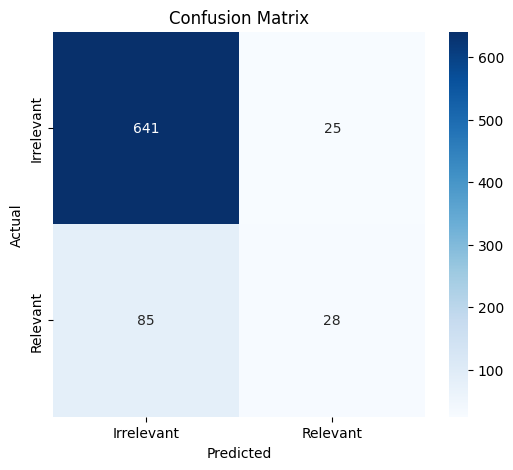

In [ ]:
if best_params:
    print("\nConfusion Matrix (Test Set):")
    cm = confusion_matrix(y_test_true, y_test_pred_final)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Irrelevant', 'Relevant'], yticklabels=['Irrelevant', 'Relevant'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
if best_params:
    # zip and download
    from google.colab import files
    import shutil

    OUTPUT_DIR = 'bert_precision'
    best_model.save(OUTPUT_DIR)
    print(f"\nBest model saved to directory: {OUTPUT_DIR}")

    shutil.make_archive(OUTPUT_DIR, 'zip', OUTPUT_DIR)
    print(f"Zipped model created: {OUTPUT_DIR}.zip. Starting download...")
    files.download(f"{OUTPUT_DIR}.zip")


Best model saved to directory: bert_precision_hyperparam
Zipped model created: bert_precision_hyperparam.zip. Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>